In [21]:
import pandas as pd
import matplotlib.pyplot as plt

### This script checks for correlation between PCs and Covariates to uncover if a PC actually displays the information of a covariate.

In [29]:
df_covariates = pd.read_csv("/dhc/groups/mpws2022cl1/input/filtered_biobank_check_cov_corr.csv")
df_pcs  = pd.read_csv("/dhc/groups/mpws2022cl1/output/50000_GRAY_50_minMaxScaling_ef_mc_2023_02_16_15_53_44_2023_03_06_11_29_52/resnet50_50_minMaxScaling_ef_mc_2023_02_16_15_53_44_L4.txt", sep=' ')

eid                       int64
Sex                     float64
Assessment_center       float64
Systolic_manual         float64
Past_tobacco            float64
Pacemaker               float64
Systolic_automatic      float64
LAX                     float64
EF                      float64
end_diastolic_volume    float64
cardiac_output          float64
cardiac_index           float64
heart_rate              float64
BMI                     float64
Age                     float64
dtype: object
eid                         0
Sex                         0
Assessment_center           0
Systolic_manual         42347
Past_tobacco             1818
Pacemaker                  34
Systolic_automatic       9167
LAX                         0
EF                       6267
end_diastolic_volume     6267
cardiac_output           6267
cardiac_index            6274
heart_rate               6267
BMI                      1873
Age                         0
dtype: int64
                eid           Sex  Assessme

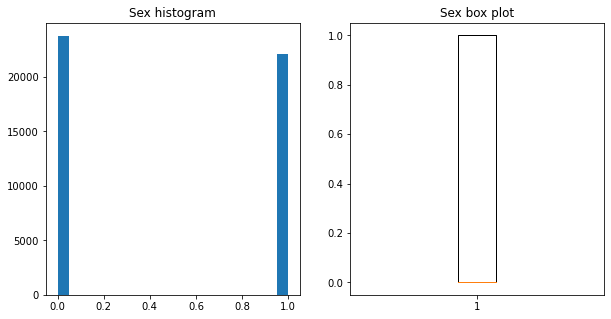

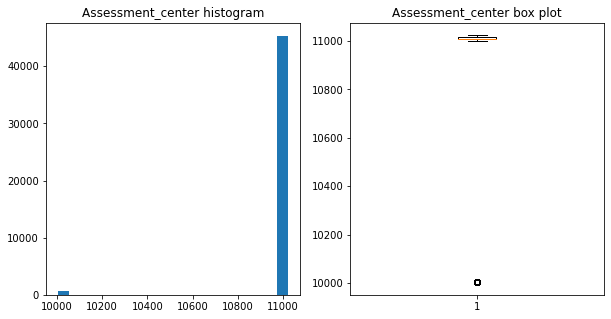

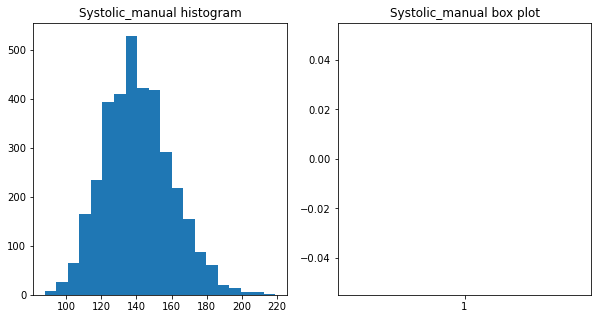

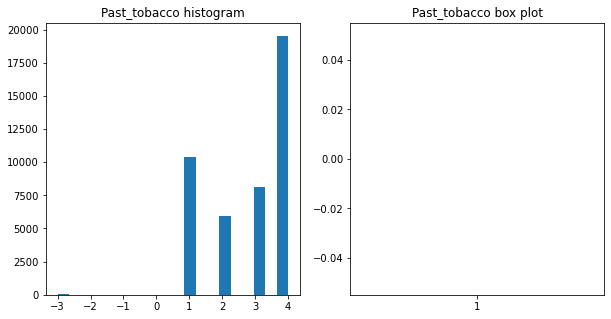

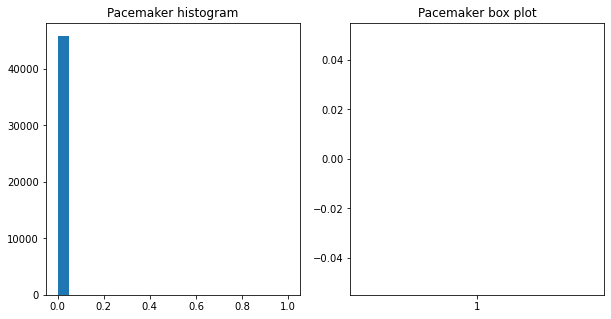

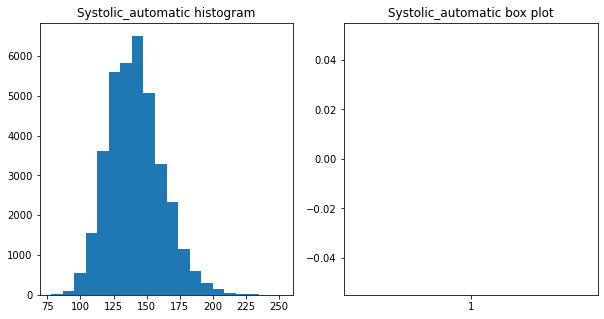

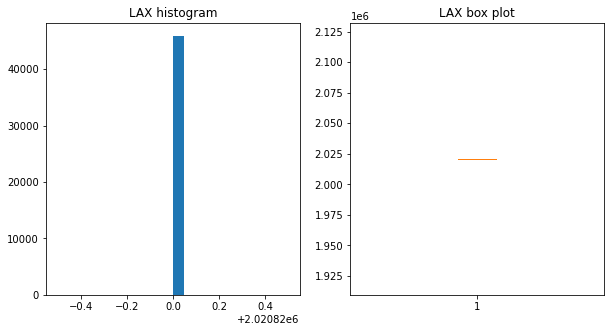

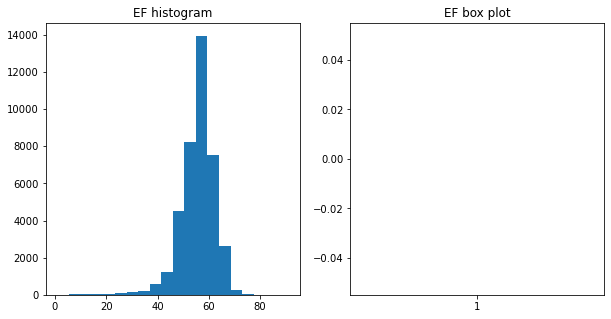

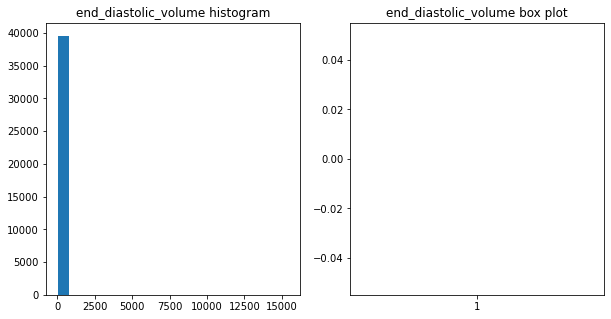

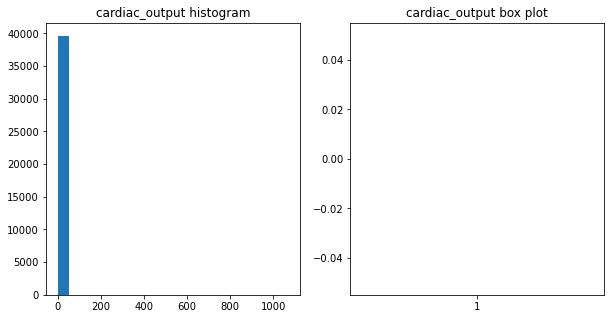

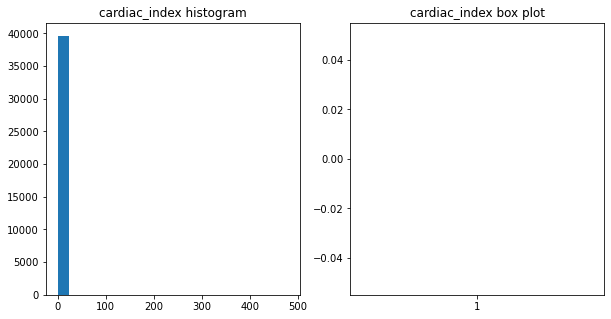

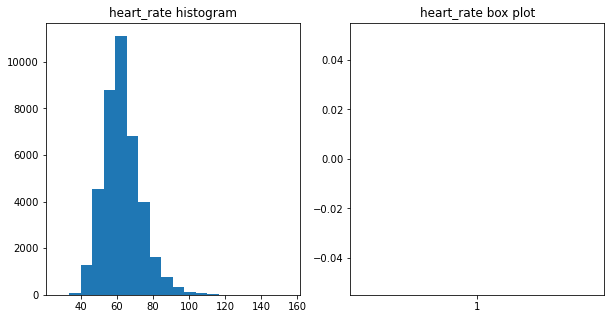

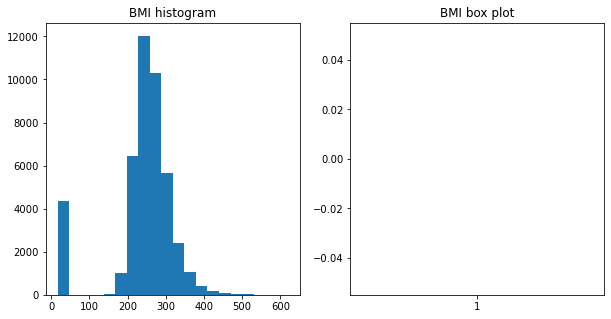

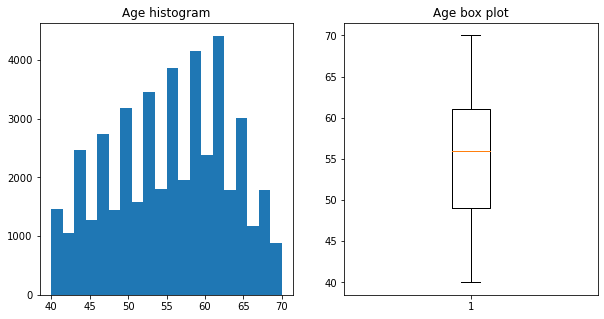

In [30]:
# Check data types
print(df_covariates.dtypes)

# Check for missing values
print(df_covariates.isnull().sum())

# Summary statistics
print(df_covariates.describe())

# Histograms and box plots
for col in df_covariates.columns:
    if df_covariates[col].dtype == 'float64':
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
        ax1.hist(df_covariates[col], bins=20)
        ax1.set_title(col + ' histogram')
        ax2.boxplot(df_covariates[col])
        ax2.set_title(col + ' box plot')
        plt.show()
    elif df_covariates[col].dtype == 'object':
        plt.figure()
        df_covariates[col].value_counts().plot(kind='bar')
        plt.title(col)
        plt.show()

In [31]:
# Convert categorical variables
df_covariates['Sex'] = df_covariates['Sex'].astype('category')
df_covariates['Pacemaker'] = df_covariates['Pacemaker'].astype('category')
df_covariates['Past_tobacco'] = df_covariates['Past_tobacco'].astype('category')
df_covariates['Assessment_center'] = df_covariates['Assessment_center'].astype('category')

# drop collumn 'LAX'
df_covariates = df_covariates.drop(columns=['LAX'])

# Print the data types of each variable
print(df_covariates.dtypes)

eid                        int64
Sex                     category
Assessment_center       category
Systolic_manual          float64
Past_tobacco            category
Pacemaker               category
Systolic_automatic       float64
EF                       float64
end_diastolic_volume     float64
cardiac_output           float64
cardiac_index            float64
heart_rate               float64
BMI                      float64
Age                      float64
dtype: object


In [32]:
# View the categories of the 'sex' column
print(df_covariates['Sex'].cat.categories)
# Check if 'Sex' column is a CategoricalIndex
print(pd.api.types.is_categorical_dtype(df_covariates['Sex']))

Float64Index([0.0, 1.0], dtype='float64')
True


### Check for correlation between PCs and covariates

In [33]:
import pandas as pd

# Assuming you have two DataFrames: df1 (covariates) and df2 (PCs)
# Rename the 'IID' column in df2 to 'eid' to match the column name in df1
df_pcs = df_pcs.rename(columns={'IID': 'eid'})

# Merge the two DataFrames on the 'eid' column
merged_df = pd.merge(df_covariates, df_pcs, on='eid')

# Calculate the correlation between the PCs and covariates
# You may customize the list of PCs and covariates as needed
pcs = ['PC_0','PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9']
covariates = ['Sex', 'Assessment_center', 'Systolic_manual', 'Past_tobacco', 'Pacemaker', 
              'Systolic_automatic', 'EF', 'end_diastolic_volume', 'cardiac_output', 
              'cardiac_index', 'heart_rate', 'BMI', 'Age']

# Get dummy variables for categorical covariates
merged_df = pd.get_dummies(merged_df, columns=['Sex', 'Assessment_center', 'Past_tobacco', 'Pacemaker'])

# Update the covariates list to include dummy variable column names
covariates = [col for col in merged_df.columns if any(cov in col for cov in covariates)]

# Compute the correlation matrix
corr_matrix = merged_df[pcs + covariates].corr()

# Get the correlations between PCs and covariates
pc_covariate_correlations = corr_matrix.loc[pcs, covariates]

print(pc_covariate_correlations)

      Systolic_manual  Systolic_automatic        EF  end_diastolic_volume  \
PC_0         0.091308            0.093641  0.326009             -0.078695   
PC_1         0.223831            0.178679  0.182723              0.039322   
PC_2         0.027019            0.033911 -0.274142              0.155088   
PC_3         0.053412            0.025771  0.214859             -0.060664   
PC_4         0.057757            0.062149 -0.074538              0.044689   
PC_5         0.023483            0.031845  0.089774              0.015630   
PC_6        -0.060951           -0.026875  0.075173             -0.048480   
PC_7        -0.063422           -0.045950 -0.059737             -0.050998   
PC_8         0.066776            0.046113 -0.091133              0.072185   
PC_9         0.097534            0.082975 -0.114992              0.079661   

      cardiac_output  cardiac_index  heart_rate       BMI       Age   Sex_0.0  \
PC_0        0.036964       0.068325    0.103674  0.038728  0.013623  0.

In [34]:
# Initialize an empty DataFrame to store correlations
pc_covariate_correlations = pd.DataFrame(index=pcs, columns=covariates)

# Compute correlations for each pair of PC and covariate using pairwise deletion
for pc in pcs:
    for covariate in covariates:
        non_missing_mask = (~merged_df[pc].isna()) & (~merged_df[covariate].isna())
        pc_covariate_correlations.loc[pc, covariate] = merged_df.loc[non_missing_mask, [pc, covariate]].corr().iloc[0, 1]

print(pc_covariate_correlations)

     Systolic_manual Systolic_automatic         EF end_diastolic_volume  \
PC_0       0.0913083          0.0936414   0.326009           -0.0786954   
PC_1        0.223831           0.178679   0.182723            0.0393224   
PC_2       0.0270191          0.0339108  -0.274142             0.155088   
PC_3       0.0534125          0.0257712   0.214859           -0.0606642   
PC_4       0.0577574          0.0621488 -0.0745377            0.0446894   
PC_5       0.0234828           0.031845  0.0897745            0.0156302   
PC_6      -0.0609507          -0.026875  0.0751735           -0.0484803   
PC_7      -0.0634223         -0.0459503 -0.0597373           -0.0509979   
PC_8       0.0667758          0.0461127 -0.0911332            0.0721848   
PC_9       0.0975345          0.0829751  -0.114992             0.079661   

     cardiac_output cardiac_index heart_rate         BMI         Age  \
PC_0      0.0369642     0.0683247   0.103674   0.0387277   0.0136231   
PC_1       0.185889      0.132